## Data Acquisition


### Flickr8k

http://academictorrents.com/details/9dea07ba660a722ae1008c4c8afdd303b6f6e53b

Flickr8k_Dataset: Contains all the images 
Flickr8k_text: Contains all captions

Training Set — 6000 images
Dev Set — 1000 images
Test Set — 1000 images

### NewsImages

NewsImage_Image: 7520 images 
title_tokens: News article title and extracted names in the article title

# Dependencies
## Tensorflow

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

2.6.0


In [3]:
Other libaries

SyntaxError: invalid syntax (Temp/ipykernel_22736/1626621764.py, line 1)

In [113]:
import string
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from tensorflow.compat.v1.keras.backend import set_session
import keras
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re
import numpy as np
import pandas as pd 
from PIL import Image
import pickle
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Image Data Explory

In [114]:
#Count the number of images
from os import listdir
## The location of the Flickr8K_ photos
path = r'C:\Users\yuxia\Documents\Project_ImageCaption\Flicker8k_Dataset'

import glob
jpgCounter = len(glob.glob1(path,"*.jpg"))
print("There are ", jpgCounter, " images in the Flicker8k photo folder")

There are  8091  images in the Flicker8k photo folder


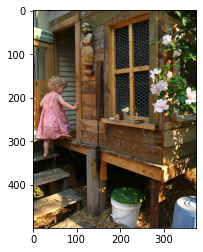

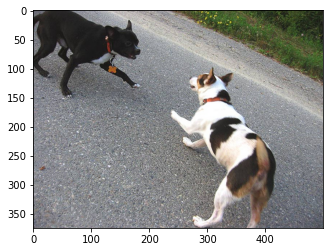

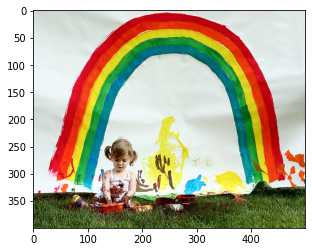

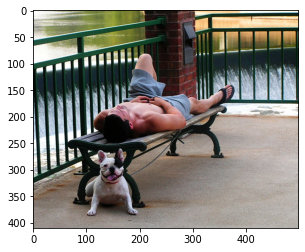

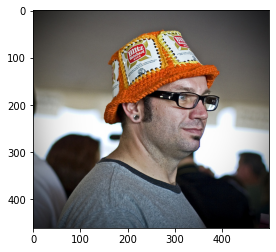

In [115]:
import matplotlib.image as mpimg
for file in os.listdir(path)[0:10]:
    if file.endswith("jpg"):
        fullpath = os.path.join(path, file)
        img=mpimg.imread(fullpath)
        plt.imshow(img)
        plt.show()

# Text Data Explory

In [116]:
## The location of the caption file
caption_file = r'C:\Users\yuxia\Documents\Project_ImageCaption\Flickr8k_text\Flickr8k.token.txt'
## read in the Flickr caption data
file = open(caption_file, 'r')
# read all text
text = file.read()
# close the file
file.close()
print(text[:482])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting



In [117]:
caption_list = []
for sentences in text.split('\n'):
  splitted = sentences.split('\t')
  if len(splitted) == 1:
      continue
  w = splitted[0].split("#")
  caption_list.append(w + [splitted[1].lower()])
caption_list[:5]

[['1000268201_693b08cb0e.jpg',
  '0',
  'a child in a pink dress is climbing up a set of stairs in an entry way .'],
 ['1000268201_693b08cb0e.jpg', '1', 'a girl going into a wooden building .'],
 ['1000268201_693b08cb0e.jpg',
  '2',
  'a little girl climbing into a wooden playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  '3',
  'a little girl climbing the stairs to her playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  '4',
  'a little girl in a pink dress going into a wooden cabin .']]

In [118]:
#The size of caption data is 5 times of size of image data
data = pd.DataFrame(caption_list,columns=["filename","index","caption"])
# Reordering columns for better readability
data = data.reindex(columns =['index','filename','caption'])

## Text Data Validation and Cleaning

In [119]:
for filenames in data["filename"]:
    found = re.search("(.(jpg)$)", filenames)
    if not found:
        print("Invalid file: ",filenames)

Invalid file:  2258277193_586949ec62.jpg.1
Invalid file:  2258277193_586949ec62.jpg.1
Invalid file:  2258277193_586949ec62.jpg.1
Invalid file:  2258277193_586949ec62.jpg.1
Invalid file:  2258277193_586949ec62.jpg.1


In [120]:
data[data['filename'] == "2258277193_586949ec62.jpg.1"]

,index,filename,caption
6730,0,2258277193_586949ec62.jpg.1,people waiting for the subway
6731,1,2258277193_586949ec62.jpg.1,some people looking out windows in a large bui...
6732,2,2258277193_586949ec62.jpg.1,three people are waiting on a train platform .
6733,3,2258277193_586949ec62.jpg.1,three people standing at a station .
6734,4,2258277193_586949ec62.jpg.1,two woman and one man standing near train trac...


In [121]:
data.shape

(40460, 3)

In [122]:
data = data[data['filename'] != '2258277193_586949ec62.jpg.1']

In [123]:
#check the new datasize
data.shape

(40455, 3)

In [124]:
unique_file_names = data.filename.unique()
#40455/5=8091
print("The number of unique file names : ",len(unique_file_names))

The number of unique file names :  8091


# Image_Text Explore

In [186]:
# https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html
def image_text_explore(data):
    for jpgfnm in unique_file_names[20:25]:
        filename = os.path.join(path, jpgfnm)
        captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
        img=cv2.imread(filename)
        plt.imshow(img)
        plt.show()
        for cap in captions:
            print(cap)

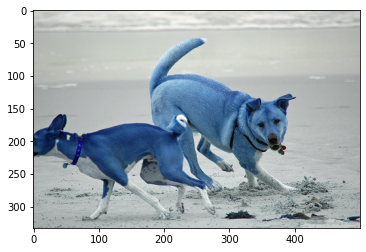

two different breeds of brown and white dogs play on the beach .
two dogs are making a turn on a soft sand beach .
two dogs playing in the sand at the beach .
two dogs playing together on a beach .
two large tan dogs play along a sandy beach .


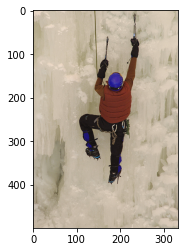

a man uses ice picks and crampons to scale ice .
an ice climber in a blue jacket and black pants is scaling a frozen ice wall .
an ice climber scaling a frozen waterfall .
a person in blue and red ice climbing with two picks .
climber climbing an ice wall


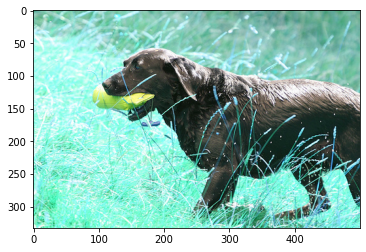

a black dog carries a green toy in his mouth as he walks through the grass .
a black dog carrying something through the grass .
a black dog has a blue toy in its mouth .
a dog in grass with a blue item in his mouth .
a wet black dog is carrying a green toy through the grass .


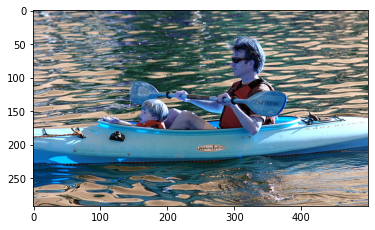

a man and a baby are in a yellow kayak on water .
a man and a little boy in blue life jackets are rowing a yellow canoe .
a man and child kayak through gentle waters .
a man and young boy ride in a yellow kayak .
man and child in yellow kayak


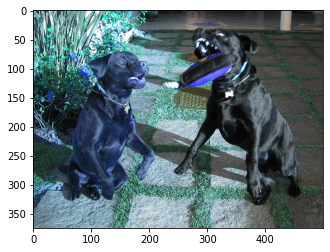

a black dog and a brown dog are jumping up to catch a red toy .
a black dog and a brown dog play with a red toy on a courtyard .
a brown and black lab are outside and the black lab is catching a toy in its mouth .
black dog snaps at red and black object as brown dog lunges .
the chocolate lab jumps too late to get the toy as the black lab captures it in the driveway .


In [187]:
image_text_explore(data)

## Preprocessing image path
- Here we are setting the path for each image so that we can load the images at once using the path set

In [195]:
full_img_name_list = []
for filenames in data["filename"]:
    full_image_path = image_dir+"/"+ filenames
    full_img_name_list.append(full_image_path)
full_img_name_list[:10]

['C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg']

## Preprocessing the captions

In [196]:
total_captions = []
for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    total_captions.append(caption)
total_captions[:10]

['<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> a girl going into a wooden building . <end>',
 '<start> a little girl climbing into a wooden playhouse . <end>',
 '<start> a little girl climbing the stairs to her playhouse . <end>',
 '<start> a little girl in a pink dress going into a wooden cabin . <end>',
 '<start> a black dog and a spotted dog are fighting <end>',
 '<start> a black dog and a tri-colored dog playing with each other on the road . <end>',
 '<start> a black dog and a white dog with brown spots are staring at each other in the street . <end>',
 '<start> two dogs of different breeds looking at each other on the road . <end>',
 '<start> two dogs on pavement moving toward each other . <end>']

## Taking 40,000 images and captions

In [197]:
def data_limiter(num,total_captions,all_img_name_vector):
  # Shuffle captions and image_names together
  train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

In [143]:
train_captions,img_name_vector = data_limiter(40000,total_captions,all_img_name_vector)

In [198]:
print("Total Captions: ", len(train_captions), " Total images: ",len(img_name_vector))

Total Captions:  40000  Total images:  40000


## Save variables in a pickle file and restore them to use it again

In [199]:
from pickle import dump

# save to file
dump(train_captions, open('captions.pkl', 'wb'))
dump(img_name_vector, open('img_names.pkl', 'wb'))
train_captions = load(open('captions.pkl', 'rb'))
img_name_vector = load(open('img_names.pkl', 'rb'))
print("Total Captions: ", len(train_captions), "Total images: ", len(img_name_vector))

Total Captions:  40000 Total images:  40000


## Let's see some image shapes

In [204]:
img_list=[]
for i in range(20):
  img_list.append(img_name_vector[i])
for j in img_list:
    img= plt.imread(j)
    print("Shape of the image", j.split('/')[1], ": ", img.shape)

Shape of the image 1956678973_223cb1b847.jpg :  (500, 375, 3)
Shape of the image 3256603992_67312b5a36.jpg :  (375, 500, 3)
Shape of the image 2938747424_64e64784f0.jpg :  (375, 500, 3)
Shape of the image 2831314869_5025300133.jpg :  (400, 500, 3)
Shape of the image 516725192_c9cdd63878.jpg :  (274, 500, 3)
Shape of the image 537559285_29be110134.jpg :  (375, 500, 3)
Shape of the image 2172493537_128bc8b187.jpg :  (334, 500, 3)
Shape of the image 2287023569_fd7a9c60b8.jpg :  (500, 354, 3)
Shape of the image 3191805046_77c334b506.jpg :  (500, 333, 3)
Shape of the image 2869491449_1041485a6b.jpg :  (350, 500, 3)
Shape of the image 140377584_12bdbdf2f8.jpg :  (375, 500, 3)
Shape of the image 132489044_3be606baf7.jpg :  (375, 500, 3)
Shape of the image 2346401538_f5e8da66fc.jpg :  (322, 500, 3)
Shape of the image 181157221_e12410ef0b.jpg :  (375, 500, 3)
Shape of the image 3192311620_99bda27fbd.jpg :  (500, 333, 3)
Shape of the image 3439243433_d5f3508612.jpg :  (333, 500, 3)
Shape of the 

## Resize image to (224,224,3)

Shape of the image:  (500, 375, 3)


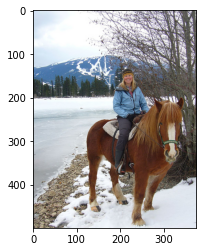

In [207]:
sample_image=os.path.join(path,"109202756_b97fcdc62c.jpg")
img= plt.imread(sample_image)
plt.imshow(img)
print("Shape of the image: ",img.shape)

## Image Augmentation

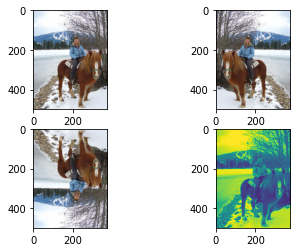

In [208]:
import imageio
def image_augment(image):
    original_img = imageio.imread(image)
    plt.figure(1)

#Original Image
    plt.subplot(221)
    plt.imshow(original_img)

#Left-Right flip Image
    left_Right_flip_img_tensor = tf.image.flip_left_right(original_img)
    flipped_img= left_Right_flip_img_tensor.numpy()
    plt.subplot(222)
    plt.imshow(flipped_img)

#Up-Down flip Image
    upside_down_flip_tensor = tf.image.flip_up_down(original_img)
    upside_down_flip= upside_down_flip_tensor.numpy()
    plt.subplot(223)
    plt.imshow(upside_down_flip)

#Gray scale Image
    gray_tensor = tf.image.rgb_to_grayscale(original_img)
    grayimg= gray_tensor.numpy()
    plt.subplot(224)
    plt.imshow(tf.squeeze(grayimg))

image_augment(sample_image)

## Resizing of images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (224, 224, 3)


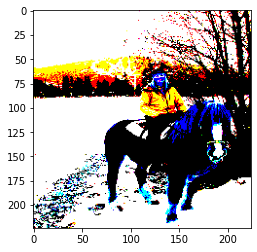

In [209]:
def resize_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

img_resized,img_resized_path = resize_image(sample_image)
print("Shape after resize :", img_resized.shape)
plt.imshow(img_resized)

## Image Histograms
- Histogram is considered as a graph or plot which is related to frequency of pixels in an Gray Scale Image
with pixel values (ranging from 0 to 255). Grayscale image is an image in which the value of each pixel is a single sample, that is, it carries only intensity information where pixel value varies from 0 to 255. 

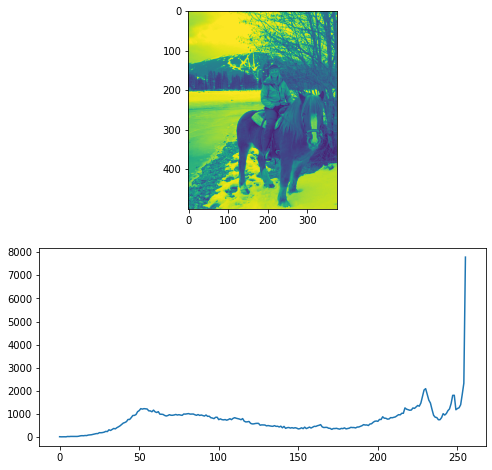

In [210]:
# importing required libraries of opencv 
import cv2 
# importing library for plotting 
from matplotlib import pyplot as plt 
def plot_image_histograms(image): 
  # reads an input image 
  img = cv2.imread(image,0) 
  # find frequency of pixels in range 0-255 
  histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
    
  # show the plotting graph of an image 
  fig = plt.figure(figsize=(8, 8))
  plt.subplot(2,1,1)
  plt.imshow(img)
  plt.subplot(2,1,2)
  plt.plot(histr) 
  plt.show() 

plot_image_histograms(sample_image)

## Pre-Trained Image Model (VGG16)

In [211]:
import tensorflow as tf
modelvgg = tf.keras.applications.VGG16(include_top=True,weights=None) # for observation on shapes

In [212]:
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [213]:
image_model = tf.keras.applications.VGG16(include_top=False,weights='imagenet')
#new_input = image_model.input # Any arbitrary shapes with 3 channels
#hidden_layer = image_model.layers[-1].output
#image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [214]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Features extractraction from VGG16

 


In [56]:
# Get unique images
encode_train = sorted(set(img_name_vector))
print(encode_train[:10])

['C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg', 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg', 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1002674143_1b742ab4b8.jpg', 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1003163366_44323f5815.jpg', 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1007129816_e794419615.jpg', 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1007320043_627395c3d8.jpg', 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1009434119_febe49276a.jpg', 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1012212859_01547e3f17.jpg', 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1015118661_980735411b.jpg', 'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1015584366_dfcec3c85a.jpg']


In [57]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
for files in image_dataset: 
    print(files.numpy())

b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1002674143_1b742ab4b8.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1003163366_44323f5815.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1007129816_e794419615.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1007320043_627395c3d8.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1009434119_febe49276a.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1012212859_01547e3f17.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1015118661_980735411b.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/1015584366_dfcec3c85a.jpg'
b'C:\\Users\\yuxia\\

b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2309327462_82a24538d4.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2309860995_c2e2a0feeb.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2310108346_e82d209ccd.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2310126952_7dc86d88f6.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2310233145_910cb5b4c8.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2311690895_0d6efe11c8.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2312731013_1a3a8e25c6.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2312746782_4528a5b818.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2312747482_20a81b2230.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2312984882_bec7849e09.jpg'
b'C:\\Users\\yuxia\\

b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/282960970_574aa1ba49.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2830309113_c79d7be554.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2830755303_2b5444ab4c.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2830869109_c4e403eae6.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2830880811_d7f66dd2cf.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2831215155_07ba8f1805.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2831217847_555b2f95ca.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2831313661_1a328acb70.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2831314869_5025300133.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/2831578193_3c997ae330.jpg'
b'C:\\Users\\yuxia\\D

b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3259579174_30a8a27058.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3259666643_ae49524c81.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3259694057_fae7484b0a.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3259757648_71edb4347b.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3259883609_6a1b46919e.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3259991972_fce3ab18b2.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3259992164_94600858b3.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3259992638_0612a40288.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3259992722_4c5e895734.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3260088697_af9b6d2393.jpg'
b'C:\\Users\\yuxia\\

b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3544573946_e03aebbfde.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3544669026_1b5c0e6316.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3544673666_ffc7483c96.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3544793763_b38546a5e8.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3544803461_a418ca611e.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3545427060_c16a8b7dfd.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3545586120_283d728a97.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3545652636_0746537307.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3545779287_8f52e06909.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/3545793128_af3af544dc.jpg'
b'C:\\Users\\yuxia\\

b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/633456174_b768c1d6cd.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/634891010_9fa189effb.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/635444010_bd81c89ab7.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/636503038_17ca82b50f.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/637342973_89f6fac1f7.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/639120223_7db6bdb61f.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/639865690_d66d480879.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/640053014_549d2f23d2.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/640203018_c0e7175831.jpg'
b'C:\\Users\\yuxia\\Documents\\Project_ImageCaption\\Flicker8k_Dataset/640409060_6af18fdd54.jpg'
b'C:\\Users\\yuxia\\Documents\

## Map each image name to the function to load the image 

In [58]:
# Feel free to change batch_size according to your system configuration
image_dataset = image_dataset.map(resize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(2)

## After this step all the images have been resized to (224,224,3)

In [59]:
image_dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>

In [60]:
from tqdm import tqdm

- An NPY file is a NumPy array file created by the Python software package with the NumPy library installed. It contains an array saved in the NumPy (NPY) file format. NPY files store all the information required to reconstruct an array on any computer, which includes dtype and shape information.

In [61]:
for img, path in tqdm(image_dataset):        
    #batch_features = image_features_extract_model(img)
    batch_features = image_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|███████████████████████████████████████████████████████████████████████████████████████████| 4046/4046 [11:59<00:00,  5.62it/s]


In [62]:
np_img =np.load('Flicker8k_Dataset/3338291921_fe7ae0c8f8.jpg.npy')

In [63]:
print(np_img)
print("Shape : {}".format(np_img.shape))

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        3.9950874 0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]
Shape : (49, 512)
